<a href="https://colab.research.google.com/github/thearseno/pynotebooks/blob/main/Growth_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Summary**

In [49]:
#Importing all the necessary libraries and parameters
from google.colab import auth
from google.cloud import bigquery
from google.auth import default
auth.authenticate_user()
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

In [36]:
#Setting up auth parameters for connecting to Google BigQuery data wharehouse
credentials, project_id = default()
project_id='datatestproj-404419'
dataset_id='userbase'
client = bigquery.Client(project=project_id, credentials=credentials)

# **Part 1: SQL Question-1**
Write a SQL query to find the total number of daily average unique active users, daily
average sessions, and daily average new users per platform (android and apple) from the
"App Opens" dataset.

In [39]:
#Assigining our SQL query to a variable "Query" for later reference and processing using Pyhon pandas library
query = f"""--First a CTE (Common Table Expression) is created to retrieve total unique occurrence count per day and platfrom for each KPI
with actives as
(select date(timestamp) as date, platform, count(distinct user_skey) as users, count(distinct session_skey) as sessions, count(case when is_first_app_open then 1 else null end) as newusers from `userbase.app_opens`
group by 1,2
order by 2)

--In the main outer query below we finalize the code by retrieving the daily averages grouped by platform for each of the requested KPIs. Our final query aggregates the average data from the precreated CTE --above.
select platform, round(avg(users)) as day_avg_actives, round(avg(sessions)) as day_avg_sessions, round(avg(newusers)) as day_avg_newusers
from actives
group by 1
order by 2 desc"""

In [38]:
#Creating a variable df(a Pandas dataframe) to load into and contain the results of our SQL query code when ran in the cell above
df = client.query(query).to_dataframe()

In [40]:
#Outputting the query result, which is already loaded into our  variable df(dataframe, can be thought of as a table container)
#We can clearly observe, that the dayly average active user count, average session count and average new users count on Apple platform are visibly higher than ones on Android platform
df.head()

,platform,day_avg_actives,day_avg_sessions,day_avg_newusers
0,apple,8379.0,10213.0,213.0
1,android,2233.0,3065.0,86.0


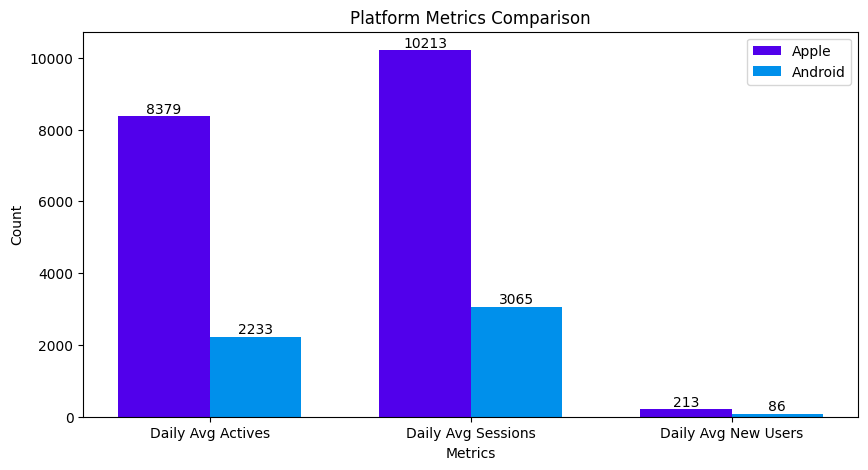

In [62]:
# New labels for the metrics
new_labels = {
    'day_avg_actives': 'Daily Avg Actives',
    'day_avg_sessions': 'Daily Avg Sessions',
    'day_avg_newusers': 'Daily Avg New Users'
}

# Relabel the columns in the DataFrame
df.rename(columns=new_labels, inplace=True)

# Set the figure size
plt.figure(figsize=(10,5))

# Set the positions and width for the bars
positions = np.arange(len(new_labels))
width = 0.35  # the width of the bars

# Plot bars for Apple with the color #D600EB
apple_bars = plt.bar(positions - width/2, df.iloc[0, 1:], width, label='Apple', color='#5100EB')

# Plot bars for Android with the color #00A3EB
android_bars = plt.bar(positions + width/2, df.iloc[1, 1:], width, label='Android', color='#0090EB')

# Function to add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

# Call the function to add labels to the bars
add_labels(apple_bars)
add_labels(android_bars)

# Adding features to the plot
plt.xlabel('Metrics')
plt.ylabel('Count')
plt.title('Platform Metrics Comparison')
plt.xticks(positions, new_labels.values())
plt.legend()  # This adds the legend

# Show the plot
plt.show()
